In this first part, we install import all the packages used

In [1]:
#Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

#Subpackages
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


#ImportFunctions
from Functions import fetch_data
from Functions import moving_average
from Functions import rsi
from Functions import macd
from Functions import lagged_return
from Functions import bollinger_bands
from Functions import pe_ratio
from Functions import daily_returns



AlreadyExistsError: Another metric with the same name already exists.

Next, we import some stock data

In [ ]:
tickers = ["AAPL", "META"]
start_date = "2015-01-01"
end_date = "2023-01-01"

stock_data = fetch_data(tickers, start_date, end_date)

Now we calculate the technical indicators for each stock

In [ ]:
# For each stock's data, compute the technical indicators and add them as new columns to the DataFrame

for ticker, data in stock_data.items():
    # Backup the 'Close' prices
    close_prices = data['Close'].copy()
    
    # 20-day Moving Average
    data['MA20'] = moving_average(data)
    
    # RSI
    data['RSI'] = rsi(data)
    
    # MACD
    data['MACD'], data['Signal_Line'] = macd(data)
    
    # 1, 2, and 3 Day Lagged Returns
    data['Lagged_Return_1'] = lagged_return(data, 2)
    data['Lagged_Return_2'] = lagged_return(data, 3)
    data['Lagged_Return_3'] = lagged_return(data, 4)
    
    # Bollinger Bands
    data['Upper_Bollinger'], data['Lower_Bollinger'] = bollinger_bands(data)
    
    # Restore 'Close' column
    data['Close'] = close_prices

    # Extract the 'Close' column
    close_prices = data['Close']
    
    # Calculate daily returns for all available days
    daily_returns = close_prices.pct_change().dropna()

    



Now that we have all the technical indicators for each stock we make a new dataframe that contains the data for all the stocks. We also do some data cleaning like removing the NANs.

In [ ]:
# Dictionary to store the split data for each stock
all_stock_data = {}

for ticker, data in stock_data.items():
    data_clean = data.dropna()  # drop rows with NaN values

    # Features: using technical indicators and lagged returns
    X = data_clean[['RSI', 'MACD', 'Signal_Line', 'Lagged_Return_1', 'Lagged_Return_2', 'Lagged_Return_3', 'Upper_Bollinger', 'Lower_Bollinger']]

    # Target: Direction of the next day's return (1 for positive, 0 for negative or non-positive)
    y = (data_clean['Close'].pct_change().shift(-1) > 0).astype(int)

    # Splitting the data: 70% train, 15% validation, 15% test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)
    
    # Store the data splits in the dictionary
    all_stock_data[ticker] = {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test
    }

# Now, `all_stock_data` contains the data splits for all stocks.

Now, we normalize the data to pe ready for Neural network

In [ ]:
from sklearn.preprocessing import StandardScaler

# Iterate over each stock's data
for ticker, data_splits in all_stock_data.items():
    scaler = StandardScaler()

    # Fit the scaler only on the training data
    data_splits['X_train'] = scaler.fit_transform(data_splits['X_train'])
    
    # Transform the validation and test data using the scaler
    data_splits['X_val'] = scaler.transform(data_splits['X_val'])
    data_splits['X_test'] = scaler.transform(data_splits['X_test'])

    # Update the dictionary with normalized data
    all_stock_data[ticker] = data_splits


Now we actually make the classifier to predict the stock direction. We use a random forest model to determine this.

In [ ]:
# Required TensorFlow imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Dictionary to store the trained models and their performances
models = {}
performances = {}

# List to store all validation accuracy scores
all_validation_accuracies = []

for ticker in all_stock_data:
    # Get data for the current stock
    X_train = all_stock_data[ticker]['X_train']
    y_train = all_stock_data[ticker]['y_train']
    X_val = all_stock_data[ticker]['X_val']
    y_val = all_stock_data[ticker]['y_val']

    # Define the neural network model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_data=(X_val, y_val))

    # Validate the model
    _, accuracy = model.evaluate(X_val, y_val, verbose=0)
    
    # Predict the validation data
    y_val_pred = (model.predict(X_val) > 0.5).astype(int).flatten()
    
    # Add the accuracy to the list
    all_validation_accuracies.append(accuracy)

    # Store the trained model and its performance
    models[ticker] = model
    performances[ticker] = {
        'Accuracy': accuracy,
        'Classification Report': classification_report(y_val, y_val_pred)
    }

    # Print out the performance for the current stock
    print(f"Performance for {ticker}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_val_pred))
    print("-------------------------------------------------")

# Calculate and print the average validation accuracy
average_validation_accuracy = sum(all_validation_accuracies) / len(all_validation_accuracies)
print(f"Average Validation Accuracy across all stocks: {average_validation_accuracy:.4f}")


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
  File "C:\Users\MARTIN~1\AppData\Local\Temp/ipykernel_9632/243431883.py", line 2, in <module>
    from tensorflow.keras.models import Sequential
  File "c:\Anaconda\lib\site-packages\tensorflow\__init__.py", line 37, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "c:\Anaconda\lib\site-packages\tensorflow\python\__init__.py", line 37, in <module>
    from tensorflow.python.eager import context
  File "c:\Anaconda\lib\site-packages\tensorflow\python\eager\context.py", line 30, in <module>
    from tensorflow.core.protobuf import config_pb2
  File "c:\Anaconda\lib\site-packages\tensorflow\core\protobuf\config_pb2.py", line 16, in <module>
    from tensorflow.core.framework import cost_graph_pb2 as tensorflow_dot_core_dot_framework_dot_cost__graph__pb2
  File "c:\Anaconda\lib\site-packages\tensorflow\core\framework\cost_

After we have trained the model on the validation set, we will now test on an out of sample test. In other words, we test on new data.

In [ ]:
# Dictionary to store test set performances
test_performances = {}

# List to store all accuracy scores
all_accuracies = []

for ticker in all_stock_data:
    # Get the test data for the current stock
    X_test = all_stock_data[ticker]['X_test']
    y_test = all_stock_data[ticker]['y_test']

    # Predict using the trained model
    y_test_pred = models[ticker].predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Store the performance on the test set
    test_performances[ticker] = {
        'Test Accuracy': test_accuracy,
        'Test Classification Report': classification_report(y_test, y_test_pred)
    }

    # Add the accuracy to the list
    all_accuracies.append(test_accuracy)

    # Print out the test performance for the current stock
    print(f"Test Performance for {ticker}:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, y_test_pred))
    print("-------------------------------------------------")

# Calculate and print the average accuracy
average_accuracy = sum(all_accuracies) / len(all_accuracies)
print(f"Average Test Accuracy across all stocks: {average_accuracy:.4f}")


Test Performance for AAPL:
Test Accuracy: 0.4633
              precision    recall  f1-score   support

           0       0.48      0.48      0.48       155
           1       0.44      0.44      0.44       145

    accuracy                           0.46       300
   macro avg       0.46      0.46      0.46       300
weighted avg       0.46      0.46      0.46       300

-------------------------------------------------
Test Performance for META:
Test Accuracy: 0.5067
              precision    recall  f1-score   support

           0       0.53      0.46      0.49       157
           1       0.48      0.56      0.52       143

    accuracy                           0.51       300
   macro avg       0.51      0.51      0.51       300
weighted avg       0.51      0.51      0.51       300

-------------------------------------------------
Average Test Accuracy across all stocks: 0.4850


Now that we have done the gridsearch we can evaluate the two models based on their accuracy. We make a table of the results from the validation test and the test data. 

In [ ]:
# Extract average accuracies for non-tuned model
non_tuned_validation_accuracy = sum([perf['Accuracy'] for perf in performances.values()]) / len(performances)
non_tuned_test_accuracy = sum([perf['Test Accuracy'] for perf in test_performances.values()]) / len(test_performances)

# Extract average accuracies for tuned model
tuned_validation_accuracy = sum([perf['Accuracy'] for perf in tuned_performances.values()]) / len(tuned_performances)
tuned_test_accuracy = sum([perf['Test Accuracy'] for perf in tuned_test_performances.values()]) / len(tuned_test_performances)

# Create a DataFrame
results = pd.DataFrame({
    'Model': ['Non-Tuned', 'Tuned'],
    'Validation Accuracy': [non_tuned_validation_accuracy, tuned_validation_accuracy],
    'Test Accuracy': [non_tuned_test_accuracy, tuned_test_accuracy]
})

# Display the results
print(results)


       Model  Validation Accuracy  Test Accuracy
0  Non-Tuned             0.494983       0.485000
1      Tuned             0.506689       0.476667


Now we start backtesting the models. We make a list that includes the predicted return and the actual return.

In [ ]:
ReturnsAndPredictionStocks = {}
ReturnsAndPredictionsValueNontuned = []
ReturnsAndPredictionsValueTuned = []
Daily_return_Value = []
Date = []

for ticker, stock_data in all_stock_data.items():
    
    # Get the test data for the current stock
    X_test = stock_data['X_test']
    y_test = stock_data['y_test']
    Returndata = data['Close']

    # Calculate the daily returns
    daily_returns = Returndata.pct_change()
    
    # Drop the first NaN value (since there is no return for the first day)
    daily_returns = daily_returns.dropna()


    # Predict using the two models
    y_test_pred_tuned = tuned_models[ticker].predict(X_test)
    y_test_pred_nontuned = models[ticker].predict(X_test)

    # Add the daily returns to a list
    Daily_return_Value.append(daily_returns.tolist())
    
    # Add the results to a list and adding date
    ReturnsAndPredictionsValueNontuned.append(y_test_pred_nontuned)
    ReturnsAndPredictionsValueTuned.append(y_test_pred_tuned)

    # Store the prediction and test for the model
    ReturnsAndPredictionStocks[ticker] = {
        'daily return': daily_returns,
        'prediction for nontuned model': y_test_pred_nontuned,
        'prediction for tuned model': y_test_pred_tuned
    }


In [ ]:
for ticker, stock_data in all_stock_data.items():
    
    # Create an empty DataFrame for each stock
    df = pd.DataFrame(columns=['Date', 'daily return', 'Nontuned model', 'Tuned model'])

    # Get the test data for the current stock
    X_test = stock_data['X_test']
    y_test = stock_data['y_test']
    Returndata = data['Close']

    # Calculate the daily returns for the current stock
    daily_returns = Returndata.pct_change()
    
    # Align daily_returns with X_test and y_test
    daily_returns = daily_returns.loc[X_test.index]

    # Predict using the two models
    y_test_pred_tuned = tuned_models[ticker].predict(X_test)
    y_test_pred_nontuned = models[ticker].predict(X_test)

    # Create a DataFrame for the current stock
    ResultsReturnAndPrediction = pd.DataFrame({
        'Date': X_test.index,
        'daily return': daily_returns.tolist(),
        'Nontuned model': y_test_pred_nontuned.tolist(),
        'Tuned model': y_test_pred_tuned.tolist()
    })

    # Append the stock DataFrame to the main DataFrame
    df = pd.concat([df, ResultsReturnAndPrediction], ignore_index=True)

    # Drop rows with NaN values in any column
    df = df.dropna()

    # Print the resulting DataFrame for each stock
    print(f"Data for {ticker}:")
    print(df)


Data for AAPL:
                    Date daily return Nontuned model Tuned model
0    2021-10-22 00:00:00    -0.050515              0           0
1    2021-10-25 00:00:00     0.012569              1           0
2    2021-10-26 00:00:00    -0.039186              0           0
3    2021-10-27 00:00:00    -0.011368              0           0
4    2021-10-28 00:00:00     0.015054              1           1
..                   ...          ...            ...         ...
295  2022-12-23 00:00:00     0.007855              0           0
296  2022-12-27 00:00:00    -0.009827              0           0
297  2022-12-28 00:00:00     -0.01078              0           0
298  2022-12-29 00:00:00     0.040131              0           0
299  2022-12-30 00:00:00     0.000665              1           0

[300 rows x 4 columns]
Data for META:
                    Date daily return Nontuned model Tuned model
0    2021-10-22 00:00:00    -0.050515              1           0
1    2021-10-25 00:00:00     0.01256

We perform the backtest and plot the results

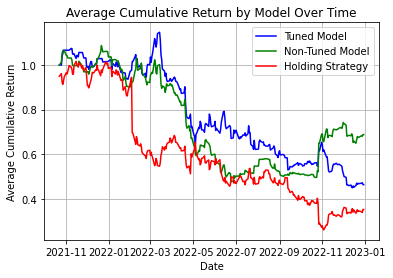

In [ ]:
# DataFrames to store cumulative returns time series for all stocks
df_cumulative_returns_tuned = pd.DataFrame(index=X_test.index)  
df_cumulative_returns_nontuned = pd.DataFrame(index=X_test.index)
df_daily_returns_all_stocks = pd.DataFrame(index=X_test.index)  # DataFrame to store daily returns for all stocks

for ticker, stock_data in all_stock_data.items():
    
    # Extract the test data and the returns data
    X_test = stock_data['X_test']
    y_test = stock_data['y_test']
    Returndata = data['Close']
    daily_returns = Returndata.pct_change().loc[X_test.index]
    df_daily_returns_all_stocks[ticker] = daily_returns  # Store daily returns for each stock

    # Predict using the two models
    y_test_pred_tuned = tuned_models[ticker].predict(X_test)
    y_test_pred_nontuned = models[ticker].predict(X_test)
    
    # Calculate strategy daily returns
    strategy_returns_tuned = daily_returns * (2 * y_test_pred_tuned - 1)
    strategy_returns_nontuned = daily_returns * (2 * y_test_pred_nontuned - 1)

    # Set the first value of strategy returns to 0 to ensure cumulative product starts at 1
    strategy_returns_tuned.iloc[0] = 0
    strategy_returns_nontuned.iloc[0] = 0

    # Calculate cumulative returns time series
    df_cumulative_returns_tuned[ticker] = (1 + strategy_returns_tuned).cumprod()
    df_cumulative_returns_nontuned[ticker] = (1 + strategy_returns_nontuned).cumprod()

# Calculate average daily returns across all stocks
average_daily_returns = df_daily_returns_all_stocks.mean(axis=1)

# Calculate cumulative returns for holding strategy
cumulative_returns_holding = (1 + average_daily_returns).cumprod()

# Calculate average cumulative returns for each date
avg_cumulative_returns_tuned = df_cumulative_returns_tuned.mean(axis=1)
avg_cumulative_returns_nontuned = df_cumulative_returns_nontuned.mean(axis=1)

# Plotting the results
plt.plot(avg_cumulative_returns_tuned, label='Tuned Model', color='blue')
plt.plot(avg_cumulative_returns_nontuned, label='Non-Tuned Model', color='green')
plt.plot(cumulative_returns_holding, label='Holding Strategy', color='red')  # Add this line
plt.xlabel('Date')
plt.ylabel('Average Cumulative Return')
plt.title('Average Cumulative Return by Model Over Time')
plt.legend()
plt.grid(True)
plt.show()


Now we calculate the sharpe ratios from the 3 strategies

In [ ]:
# Calculate daily returns for each strategy
daily_returns_tuned = df_cumulative_returns_tuned.pct_change().mean(axis=1)
daily_returns_nontuned = df_cumulative_returns_nontuned.pct_change().mean(axis=1)

# 1. Calculate the mean daily return for each strategy
mean_return_tuned = daily_returns_tuned.mean()
mean_return_nontuned = daily_returns_nontuned.mean()
mean_return_holding = average_daily_returns.mean()

# 2. Calculate the standard deviation of daily returns for each strategy
std_dev_tuned = daily_returns_tuned.std()
std_dev_nontuned = daily_returns_nontuned.std()
std_dev_holding = average_daily_returns.std()

# 3. Compute the Sharpe ratio for each strategy (assuming risk-free rate is 0)
sharpe_ratio_tuned = mean_return_tuned / std_dev_tuned
sharpe_ratio_nontuned = mean_return_nontuned / std_dev_nontuned
sharpe_ratio_holding = mean_return_holding / std_dev_holding

print(f"Sharpe Ratio (Tuned Model): {sharpe_ratio_tuned:.4f}")
print(f"Sharpe Ratio (Non-Tuned Model): {sharpe_ratio_nontuned:.4f}")
print(f"Sharpe Ratio (Holding Strategy): {sharpe_ratio_holding:.4f}")


Sharpe Ratio (Tuned Model): -0.0939
Sharpe Ratio (Non-Tuned Model): -0.0276
Sharpe Ratio (Holding Strategy): -0.0716


Next part of the code will focus more on evaluating the machine learning models. Here we check what kind of parameters the model uses and how well it guesses the direction of the stocks. 

<Figure size 864x576 with 0 Axes>

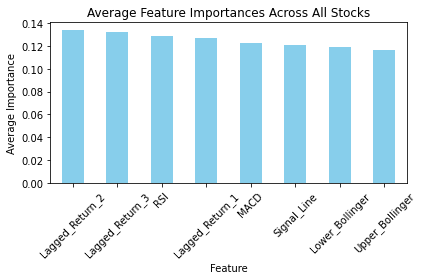

In [ ]:
# Initialize a zero-filled array with the same shape as feature_importances to store cumulative importances
cumulative_importances = np.zeros_like(models[list(models.keys())[0]].feature_importances_)

# Loop through each stock ticker in the models dictionary
for ticker, clf in models.items():

    # Add the feature importances to the cumulative_importances array
    cumulative_importances += clf.feature_importances_

# Calculate the average feature importances
average_importances = cumulative_importances / len(models)

# Get the names of the features from the training data for any stock (since they share the same features)
feature_names = all_stock_data[list(all_stock_data.keys())[0]]['X_train'].columns

# Create a DataFrame to hold the feature names and their average importances
df_average_importances = pd.DataFrame({
    'Feature': feature_names,
    'Average Importance': average_importances
})

# Sort the DataFrame by average importance in descending order
df_average_importances = df_average_importances.sort_values(by='Average Importance', ascending=False)

# Plot the average feature importances
plt.figure(figsize=(12, 8))
df_average_importances.plot(kind='bar', x='Feature', y='Average Importance', legend=False, color='skyblue')
plt.title(f'Average Feature Importances Across All Stocks')
plt.ylabel('Average Importance')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In the plot above we have the most important features of the simple nontuned model.

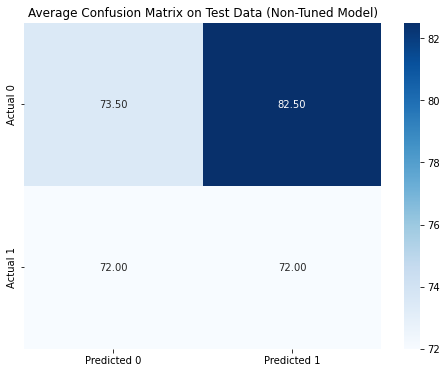

In [ ]:

# Initialize a cumulative confusion matrix with zeros
cumulative_cm = np.zeros((2, 2))

# Loop through each stock ticker in the models dictionary
for ticker, clf in models.items():
    X_test = all_stock_data[ticker]['X_test']
    y_test = all_stock_data[ticker]['y_test']
    
    # Get predictions on the test set
    y_test_pred = clf.predict(X_test)
    
    # Add the confusion matrix for the current stock to the cumulative matrix
    cumulative_cm += confusion_matrix(y_test, y_test_pred)

# Calculate the average confusion matrix
average_cm = cumulative_cm / len(models)

# Plot the average confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(average_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Average Confusion Matrix on Test Data (Non-Tuned Model)")
plt.show()
